# Lecture 2

Load up a nice Python environment, with high-resolution plots for a modern LCD:

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


We are going to be trying to fit and extract some information from the public data released for GW150914.  First a disclaimer: this *is not what LIGO actually does*; our "just so" stories are significantly more sophisticated than what we will do here.  If you want to know what was actually done to fit the recent BBH events, you can read about it in our papers, particularly:

 * The GW150914 discovery paper [here](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)
 * The "parameter estimation" paper for GW150914 [here](https://arxiv.org/abs/1602.03840v2)
 * The discovery papers for [GW151226](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.241103), [GW170104](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.118.221101), and the lesser-significance (I want to believe it's a gravitational wave, but you are free to form your own opinions) [LVT151012](http://arxiv.org/abs/1606.04856v3)
 
and (of course) references therein.  Here we are just trying to give a flavour of the analysis.

We will be partially following the [BBH Event Tutorial](https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html) from the [LIGO Open Science Center](http://losc.ligo.org) [tutorial](https://losc.ligo.org/tutorials/) page.  I encourage you to read the whole tutorial at LOSC and, generally, to explore our data releases (one for each "GW" event) and the tools we have provided for learning from them.  

You will need to download the large files containing 4096 seconds of data surrounding GW150914 yourself (I am not putting them in the [git repository](https://github.com/farr/GWDataAnalysisSummerSchool) where these lectures are archived because they are quite large):
 * [Hanford data at 4096 Hz sampling](https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126259446-32.hdf5)
 * [Hanford data at 16384 Hz sampling](https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126259446-32.hdf5)
 * [Livingston data at 4096 Hz sampling](https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_4_V1-1126259446-32.hdf5)
 * [Livingston data at 16384 Hz sampling](https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_16_V1-1126259446-32.hdf5)
 * [a Python library](https://losc.ligo.org/s/sample_code/readligo.py) to read in the data (you will also need [h5py](http://www.h5py.org) since the data files are stored in HDF5 format).
 
As in lecture 1, you will need to install the [seaborn](https://seaborn.pydata.org) library for pretty and useful statistical plots.

In [78]:
import corner
import h5py
import pystan
import scipy.interpolate as si
import scipy.signal as ss
import seaborn as sns
import readligo as rl

Make the plots pretty for the notebook:

In [3]:
sns.set_context('talk') # sns.set_context('notebook') will work better if you are following along at home
sns.set_style('ticks')
sns.set_palette('colorblind')

In [4]:
strain_h1, time_h1, channels_h1 = rl.loaddata('H-H1_LOSC_4_V1-1126259446-32.hdf5', 'H1')
fsampling = 4096
dt_sampling = time_h1[1]-time_h1[0]

This doesn't look like a gravitational wave at all:

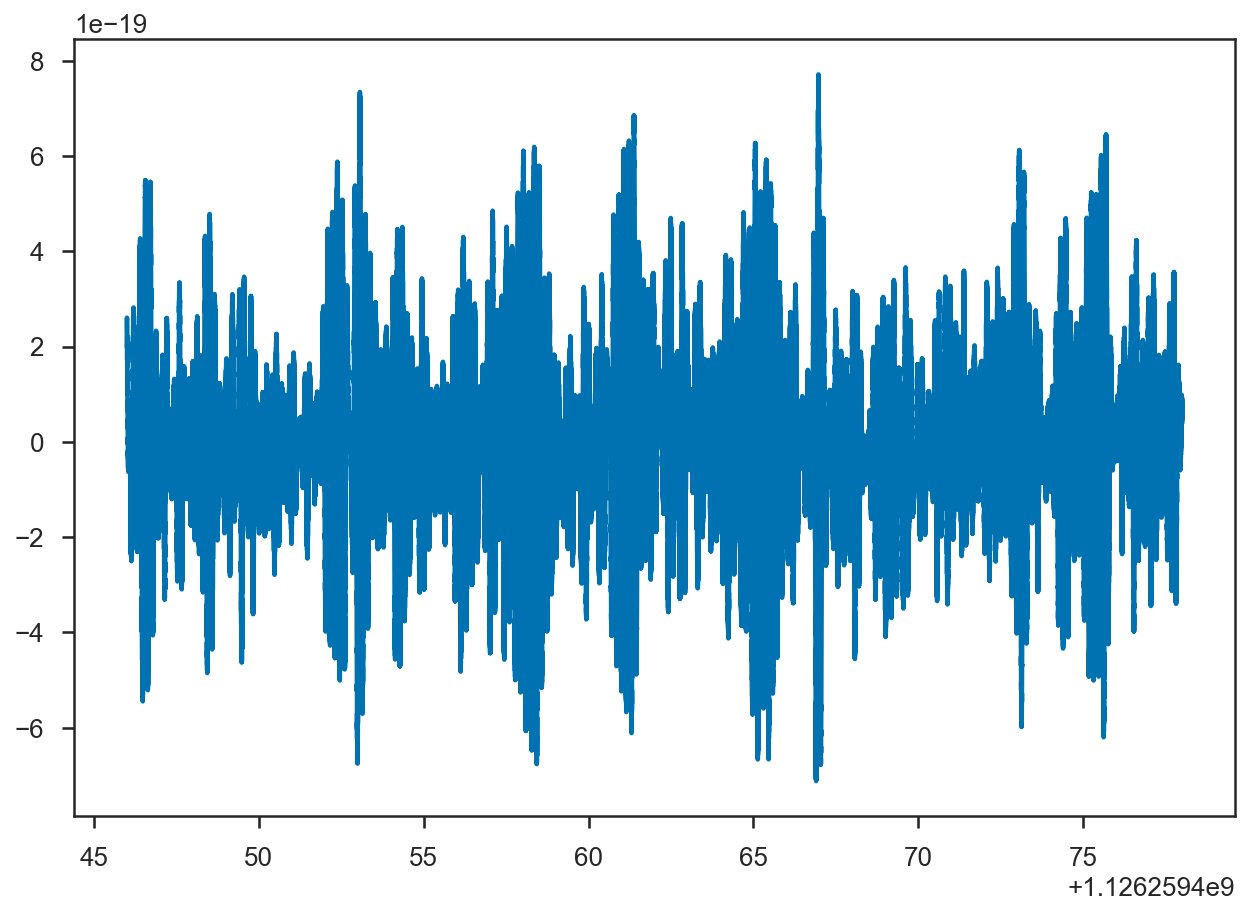

In [5]:
plot(time_h1, strain_h1)

The problem is that the LIGO data are dominated by *low frequency noise*, *calibration lines*, and other *narrowband detector lines*.  Fortunately, none of this noise "looks like" a GW signal.

 * Discuss "PSD," "stationarity," etc.
 * Formalise a bit "looks like."

Let's estimate the PSD for this data.  Since we know in advance that we are going to be interested in about 0.25 seconds around GW150914, we will use this "segment length" in the PSD estimate:

In [6]:
fs, psd_h1 = ss.welch(strain_h1, nperseg=fsampling/4, fs=fsampling)

(10, 2797.650445833001, 2.2231005898503085e-47, 1e-40)

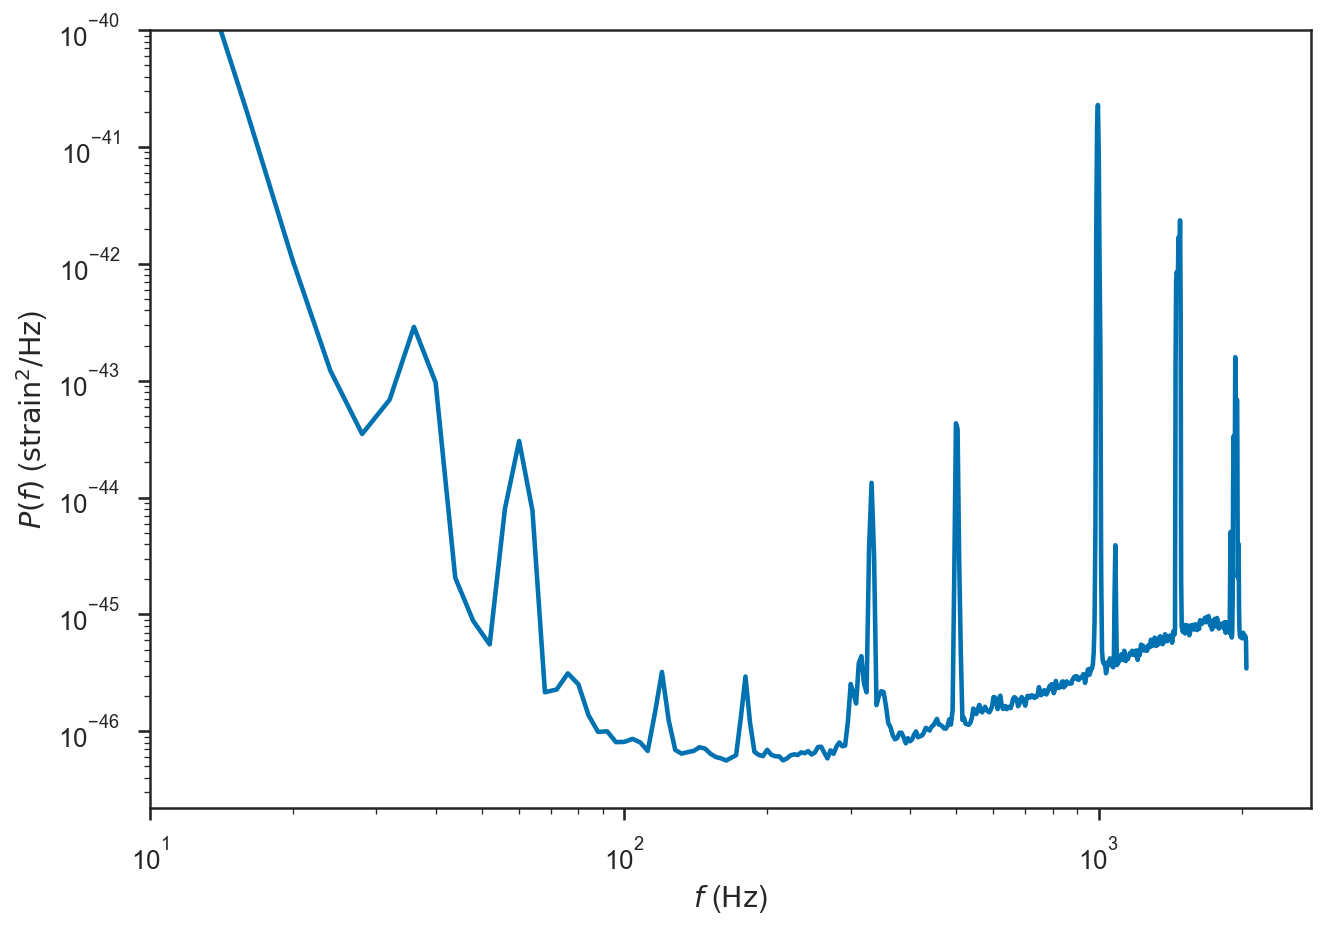

In [7]:
loglog(fs, psd_h1)
ylabel(r'$P(f)$ ($\mathrm{strain}^2 / \mathrm{Hz}$)')
xlabel(r'$f$ ($\mathrm{Hz}$)')
axis(xmin=10, ymax=1e-40)

 * Discussion of whitening

In [8]:
# Copied from LOSC tutorial
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [9]:
white_strain_h1 = whiten(strain_h1, si.interp1d(fs, psd_h1), dt_sampling)

In [10]:
tGW150914 = 1126259462.422
tselector = (time_h1 > tGW150914-0.2) & (time_h1 < tGW150914+0.05)

Hmmm....

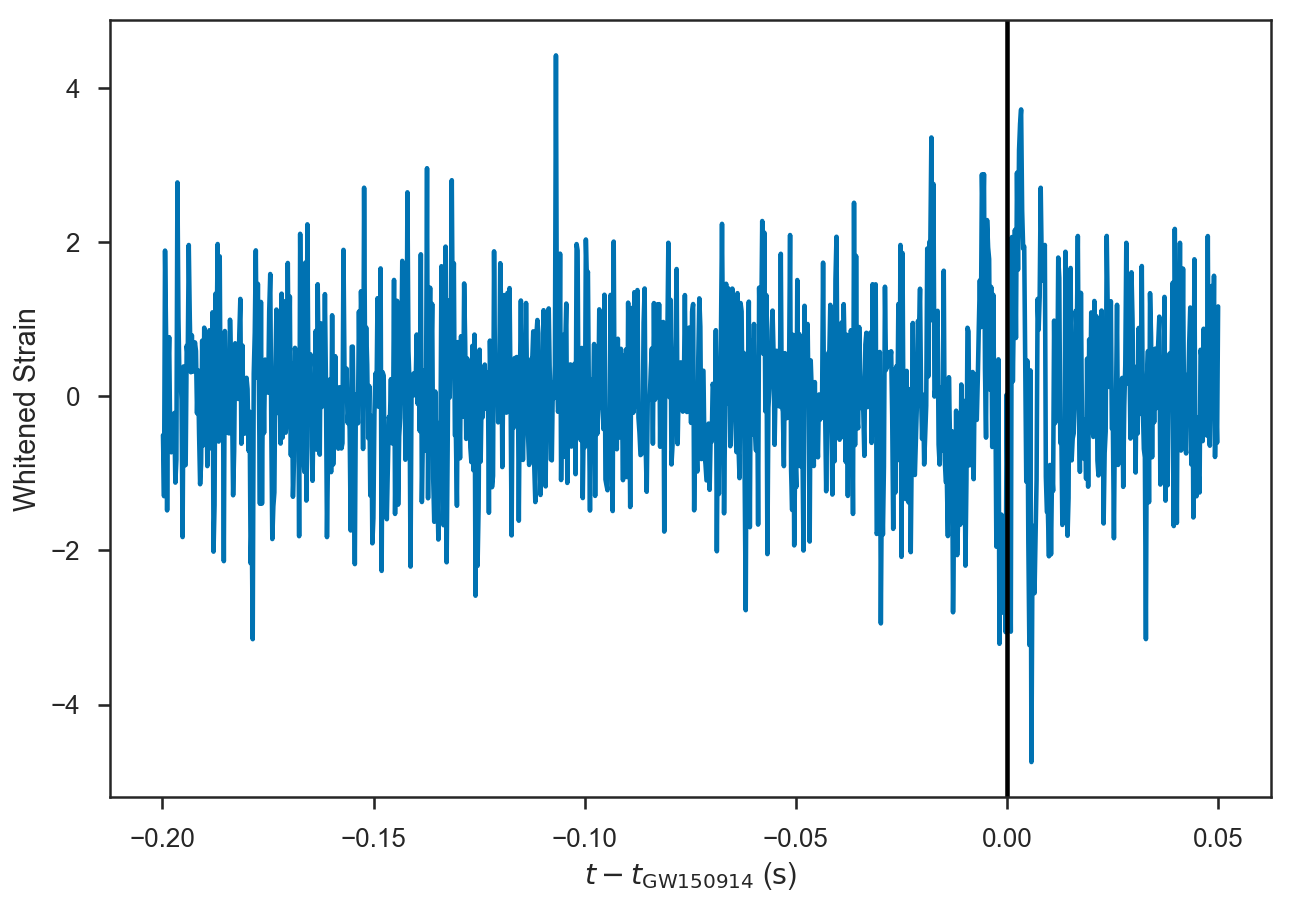

In [11]:
plot(time_h1[tselector]-tGW150914, white_strain_h1[tselector])
axvline(0.0, color='k')
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

There is lots of high-frequency noise here, but perhaps there is something where I have drawn the line.  Since we know that the signal is low-frequency (i.e. high-mass), let's low-pass filter it.  Note that this messes up the normalisation of the whitening we did earlier.  Roughly, we are averaging over four neighbouring data points, which will reduce our uncertainty from $\sigma = 1$ to $\sigma = 1/2$.

In [160]:
def low_pass_filter_amplitude(fs, frolloff, fwidth):
    return 1.0/(1.0 + exp((fs - frolloff)/fwidth))
def low_pass_filter(data, dt):
    Nt = data.shape[0]
    fs = np.fft.rfftfreq(Nt, dt)
    
    filt = low_pass_filter_amplitude(fs, 512.0, 16.0) # Rolloff at 512 Hz over 16 Hz
    
    dataf = np.fft.rfft(data)
    return np.fft.irfft(dataf*filt, Nt)

In [161]:
white_pass_strain_h1 = low_pass_filter(white_strain_h1, dt_sampling)

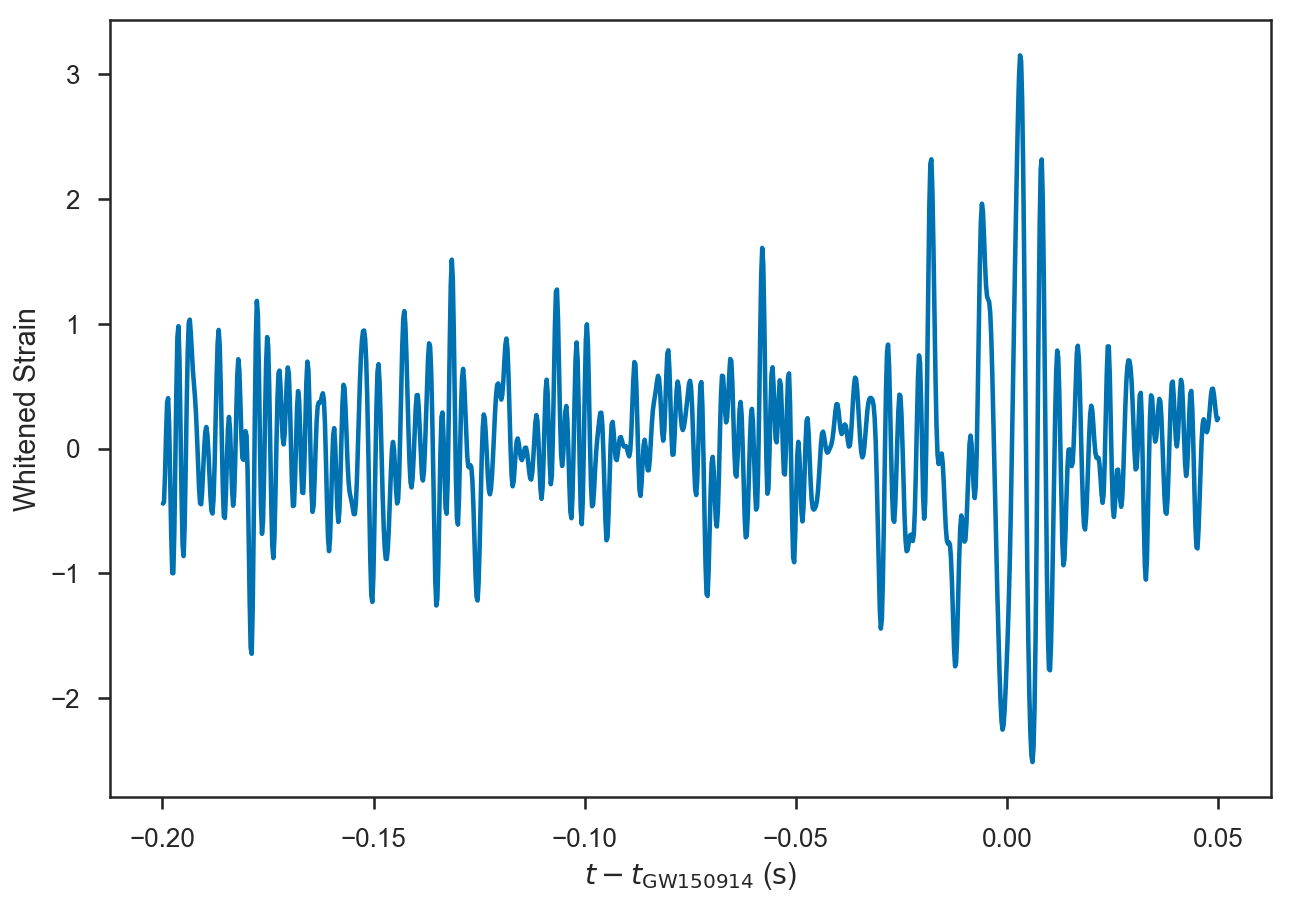

In [142]:
plot(time_h1[tselector]-tGW150914, white_pass_strain_h1[tselector])
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

["Basic physics" paper](https://arxiv.org/pdf/1608.01940.pdf) discussion; for "real" post Newtonian expansions, see [Blanchet (2014)](https://link.springer.com/content/pdf/10.12942%2Flrr-2014-2.pdf)

The basic physics paper gives the evolution of the *inspiral* phase with time:

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


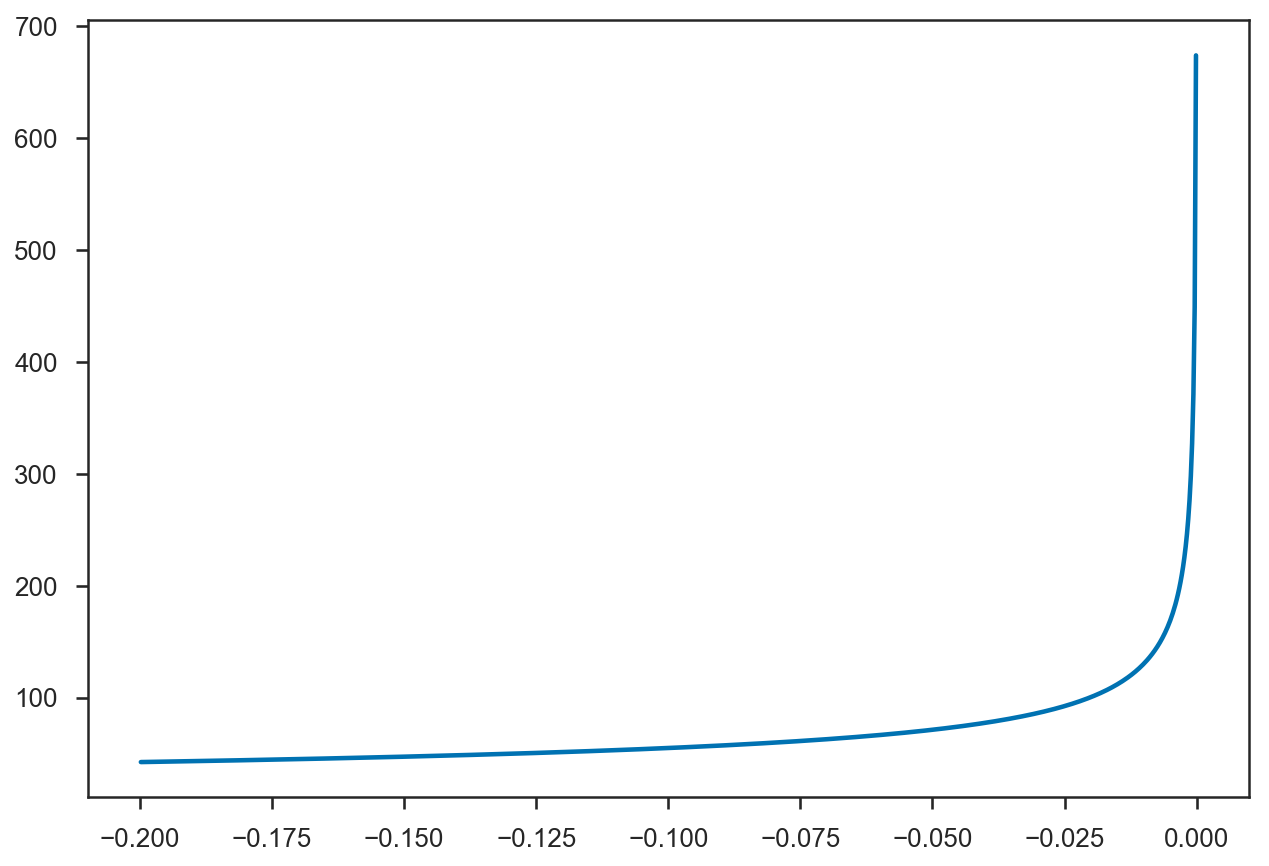

In [15]:
ts = time_h1[tselector]-tGW150914
fs = (1100.0*(4.9e-6*20.0)**(5.0/3.0)*(-ts))**(-3.0/8.0)
plot(ts, fs)

Because the inspiral phase reaches $\infty$ in finite time, we will have to do something.  After some discussion, we ended up choosing:
 * To truncate the frequency at some $f_\mathrm{max}$ (a parameter).
 * To have an exponentially-damped decay once the frequency reaches $f_\mathrm{max}$.
 * To use a power-law amplitude with unknown index.

So
$$
h(t) = A_{100} \left( \frac{f(t)}{100 \, \mathrm{Hz}} \right)^\alpha \cos \left( \phi_0 + 2\pi f(t) \left( t - t_0 \right) \right) \frac{1}{1 + \exp\left( \frac{t - t\left(f_\mathrm{max}\right)}{\tau} \right)}
$$
with
$$
f(t) = \begin{cases}
\left( \frac{\left( 8 \pi \right)^{8/3}}{5} \left( \frac{G \mathcal{M}}{c^3} \right)^{3/5} \left( t_c - t \right) \right)^{-3/8} & f(t) < f_\mathrm{max} \\
f_\mathrm{max} & \mathrm{otherwise}
\end{cases}
$$

In [ ]:
def basic_waveform(ts, A100, dlnAdlnf, Mc, tc, phic, max_freq, tau):
    fs = (1100.0*(4.9e-6*Mc)**(5.0/3.0)*(tc-ts))**(-3.0/8.0)
        
    fs[(fs >= max_freq) | (ts >= tc)] = max_freq
    
    amps = A100*(fs/100)**dlnAdlnf
    
    return (1.0-low_pass_filter_amplitude(fs, 30.0, 2.0))*amps*cos(phic + 2.0*pi*fs*(ts-tc))*low_pass_filter_amplitude(ts, tc, tau)

Here is a demonstration of the waveform, showing that it's reasonable---though hardly optimal.

In [ ]:
plot(time_h1[tselector]-tGW150914, basic_waveform(time_h1[tselector]-tGW150914, 2.0, 1.25, 30.0, 0.003, 0.0, 250.0, 0.005))
plot(time_h1[tselector]-tGW150914, white_pass_strain_h1[tselector])
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

And it is implemented in our Stan model:

In [146]:
model = pystan.StanModel(file='phenom_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a1b614a981deffde56f4aab95681689 NOW.


A fit.  This problem is significantly harder than the linear fits we have been doing, so expect

 1. It will take several minutes.
 1. The sampler will need a longer number of steps to properly warm up and draw independent samples from the data.  Because we don't need so many output points, we will `thin` the output, recording only every $N$-th step.

In [147]:
data = {
    'nt': sum(tselector),
    'ts': time_h1[tselector]-tGW150914,
    'h_obs': white_pass_strain_h1[tselector],
    'tphi': 0.0
}

This fit turns out to be quite a pain, so let's initialise near a maximum of the parameter space:

In [150]:
init = []
while len(init) < 4:
    try:
        init.append(model.optimizing(data=data))
    except RuntimeError:
        pass
init

[OrderedDict([('A100', array(1.71330384603154)),
              ('dlnAdlnf', array(6.081546482446814)),
              ('phi', array(3.905988173582865)),
              ('tc', array(0.004245631987675738)),
              ('Mc', array(22.874587558635014)),
              ('max_freq', array(100.36296969802953)),
              ('tau', array(0.00023166394051398625)),
              ('sigma', array(0.5746028993125364)),
              ('h_model',
               array([  4.12946065e-03,   4.25912601e-03,   4.38353819e-03, ...,
                       -2.91536755e-85,  -9.14497163e-86,  -2.75767170e-86]))]),
 OrderedDict([('A100', array(0.5847734657238002)),
              ('dlnAdlnf', array(3.9718546868075744)),
              ('phi', array(4.5982154548791305)),
              ('tc', array(-0.022026560044644084)),
              ('Mc', array(14.392532713923291)),
              ('max_freq', array(106.04600216524898)),
              ('tau', array(0.05562186244221989)),
              ('sigma', array(0.6543

By eye, we can look for the best initialisation point, which seems to be 0:

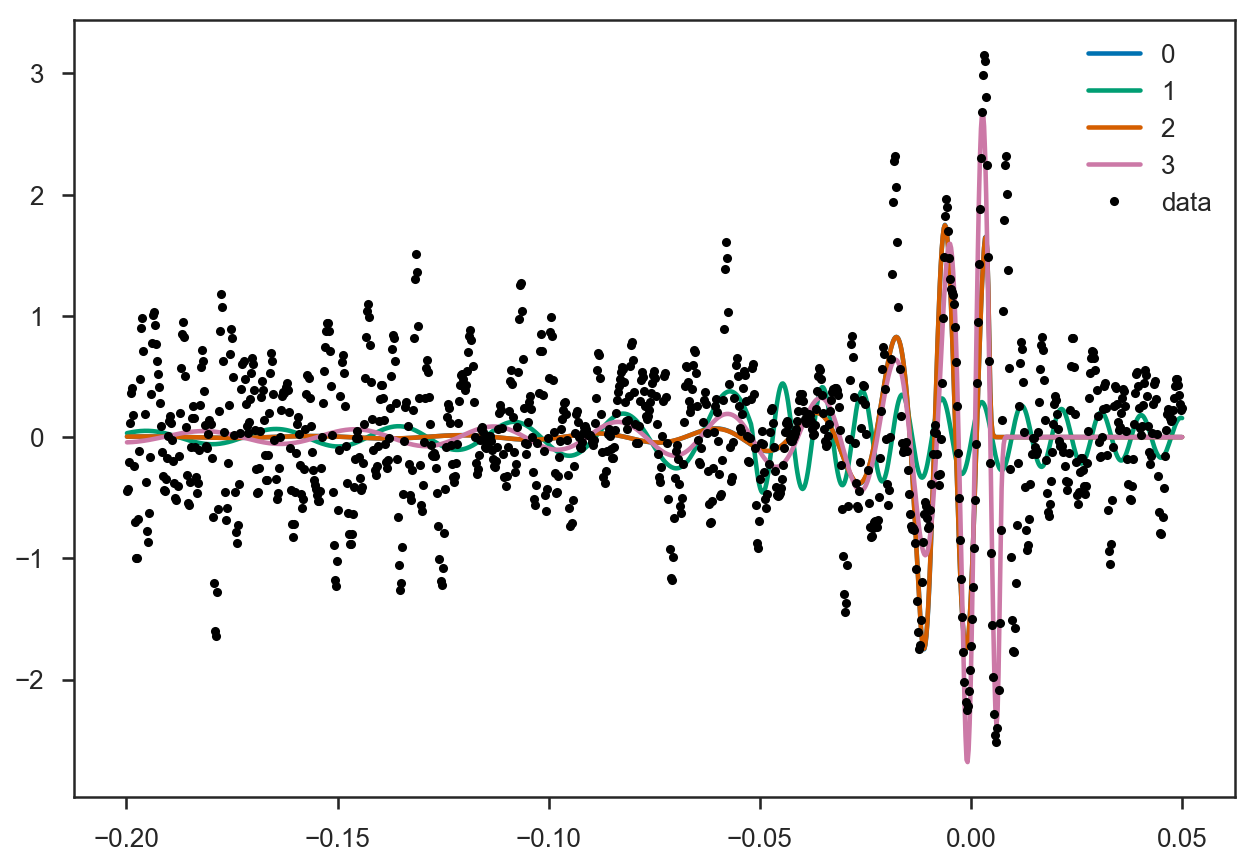

In [151]:
for i, params in enumerate(init):
    plot(time_h1[tselector]-tGW150914, params['h_model'], label=str(i))
plot(time_h1[tselector]-tGW150914, white_pass_strain_h1[tselector], '.k', label='data')
legend(loc='best')

In [152]:
fit = model.sampling(data=data, init=(init2[3],)*4)
fit

Inference for Stan model: anon_model_3a1b614a981deffde56f4aab95681689.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A100             0.9  1.0e-3   0.05   0.81   0.87    0.9   0.93   0.99   2066    1.0
dlnAdlnf        2.75  2.8e-3   0.13    2.5   2.66   2.74   2.83   3.01   2082    1.0
phi             3.77  1.2e-3   0.05   3.67   3.73   3.77    3.8   3.87   1844    1.0
tc            8.6e-3  1.7e-6 1.0e-4 8.4e-3 8.6e-3 8.6e-3 8.7e-3 8.8e-3   3589    nan
Mc             20.73  4.5e-3   0.24  20.28  20.57  20.72  20.88   21.2   2739    1.0
max_freq      155.83    0.04   1.81 152.22  154.6 155.85 157.04 159.44   1894    1.0
tau           2.5e-4  1.2e-6 7.0e-5 1.4e-4 2.0e-4 2.4e-4 2.9e-4 4.0e-4   3584    nan
sigma           0.51  1.9e-4   0.01   0.49    0.5   0.51   0.52   0.53   3595    1.0
h_model[0]     -0.07  3.2e-4   0.01   -0.1  -0

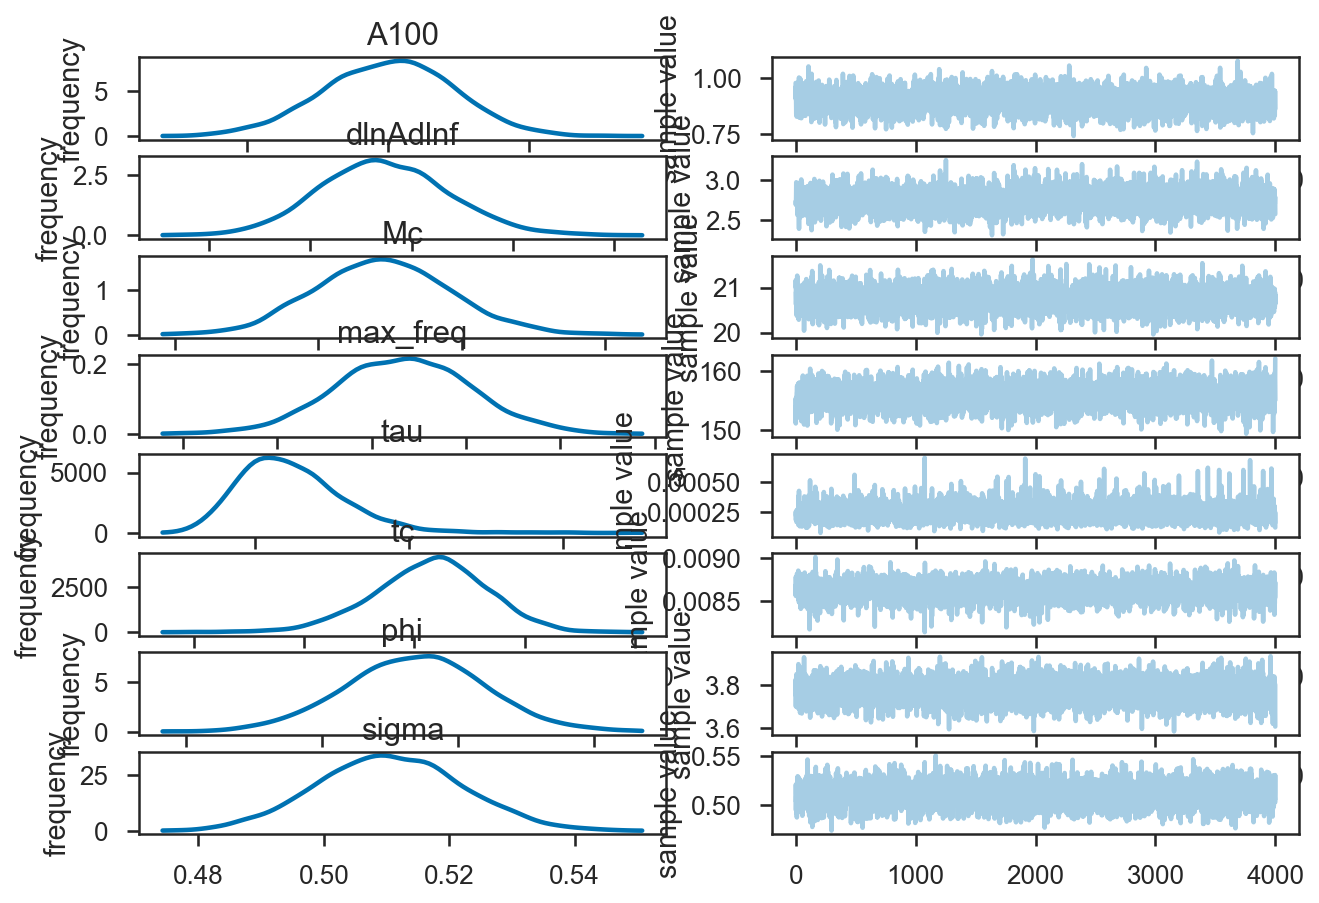

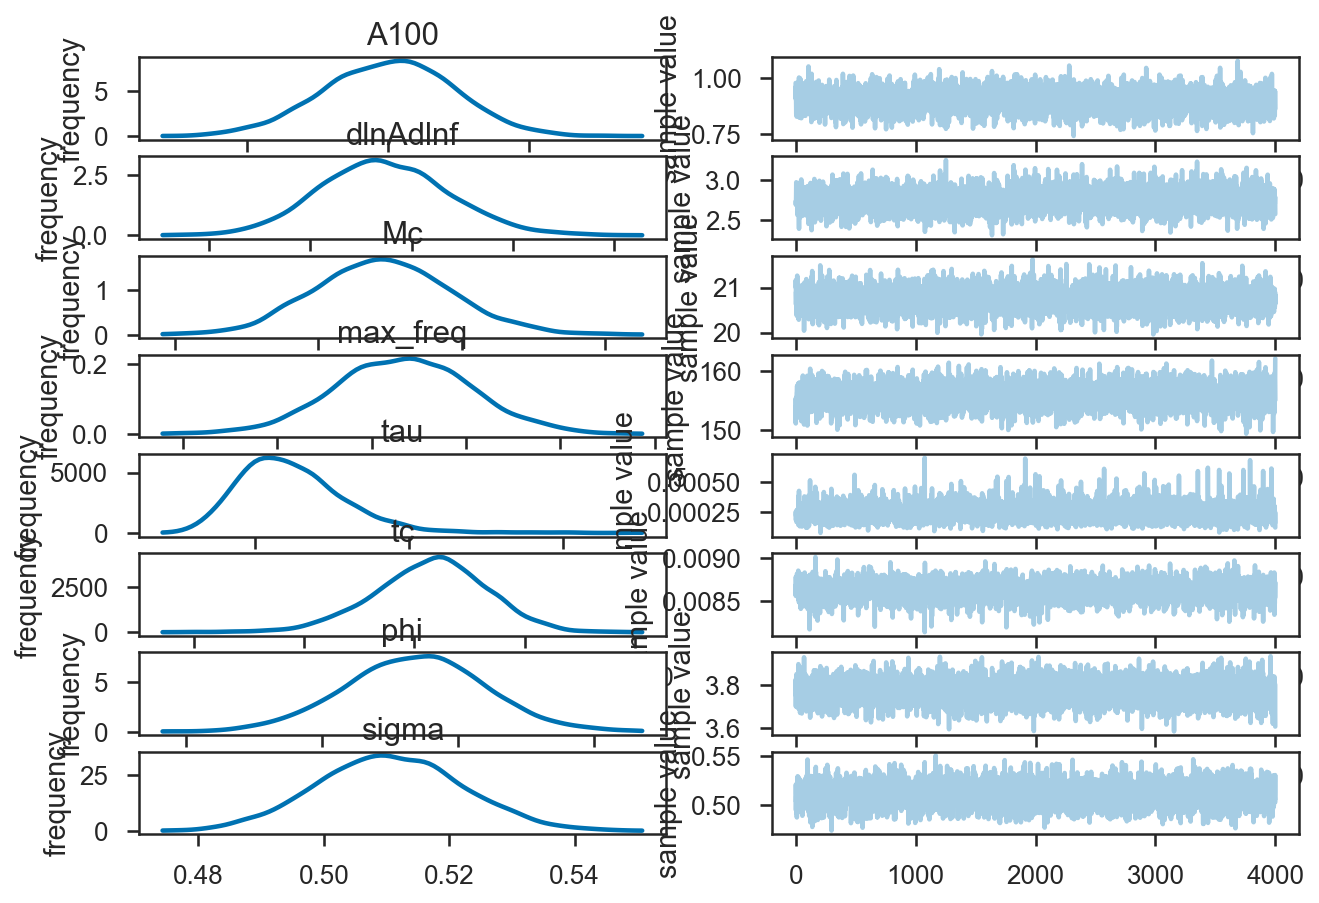

In [154]:
fit.plot(pars=['A100', 'dlnAdlnf', 'Mc', 'max_freq', 'tau', 'tc', 'phi', 'sigma'])

In [155]:
chains = fit.extract(permuted=True)

Let's look at a few parameters.  First the chirp mass: $\mathcal{M}$.  Note that the true chirp mass of the event is $\sim 30 \, M_\odot$, so our model (which is "0 pN") has *significant* systematic bias!

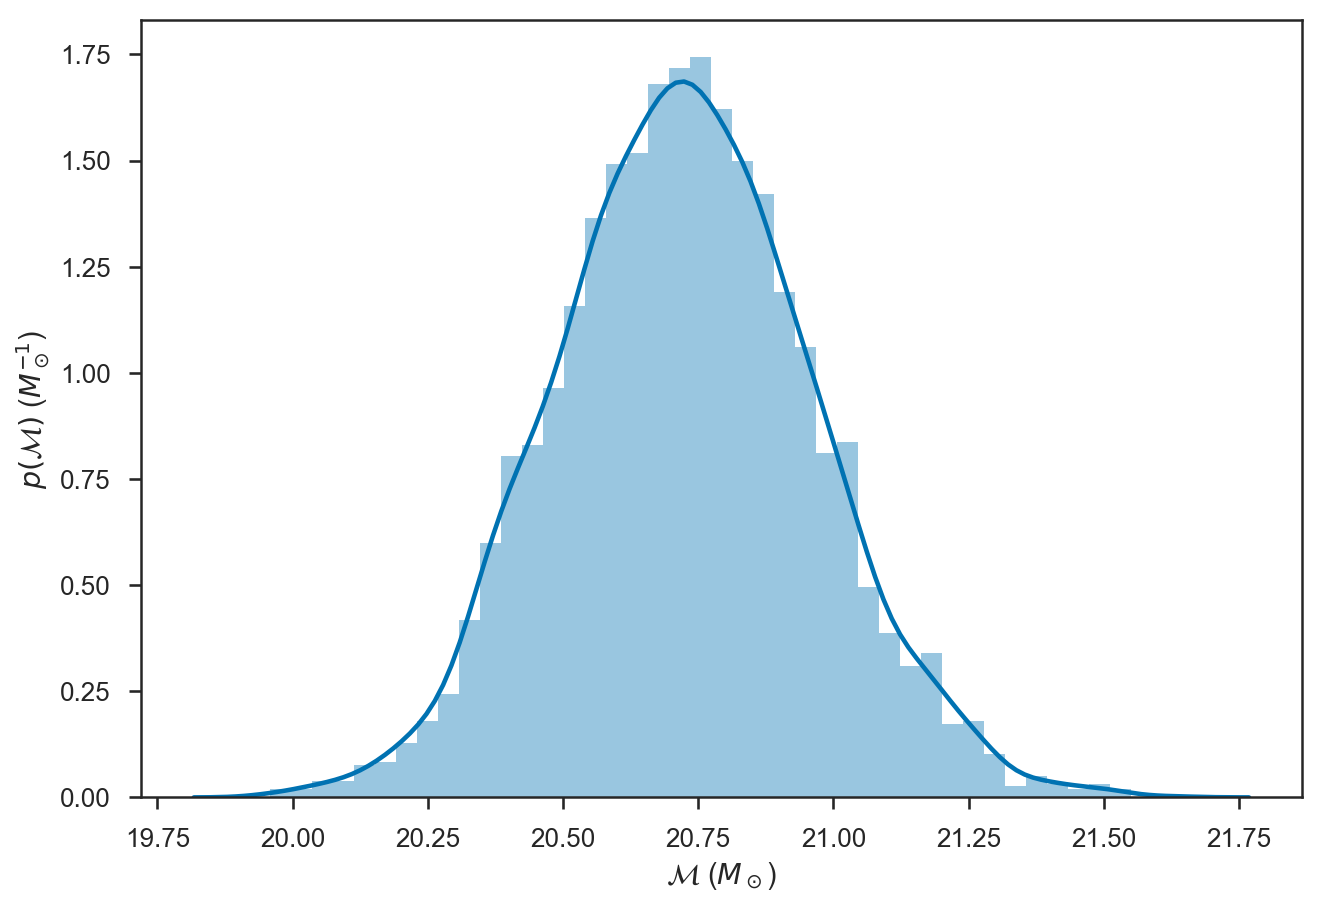

In [156]:
sns.distplot(chains['Mc'])
xlabel(r'$\mathcal{M}$ ($M_\odot$)')
ylabel(r'$p\left( \mathcal{M} \right)$ ($M_\odot^{-1}$)')

The maximum frequency is also interesting:

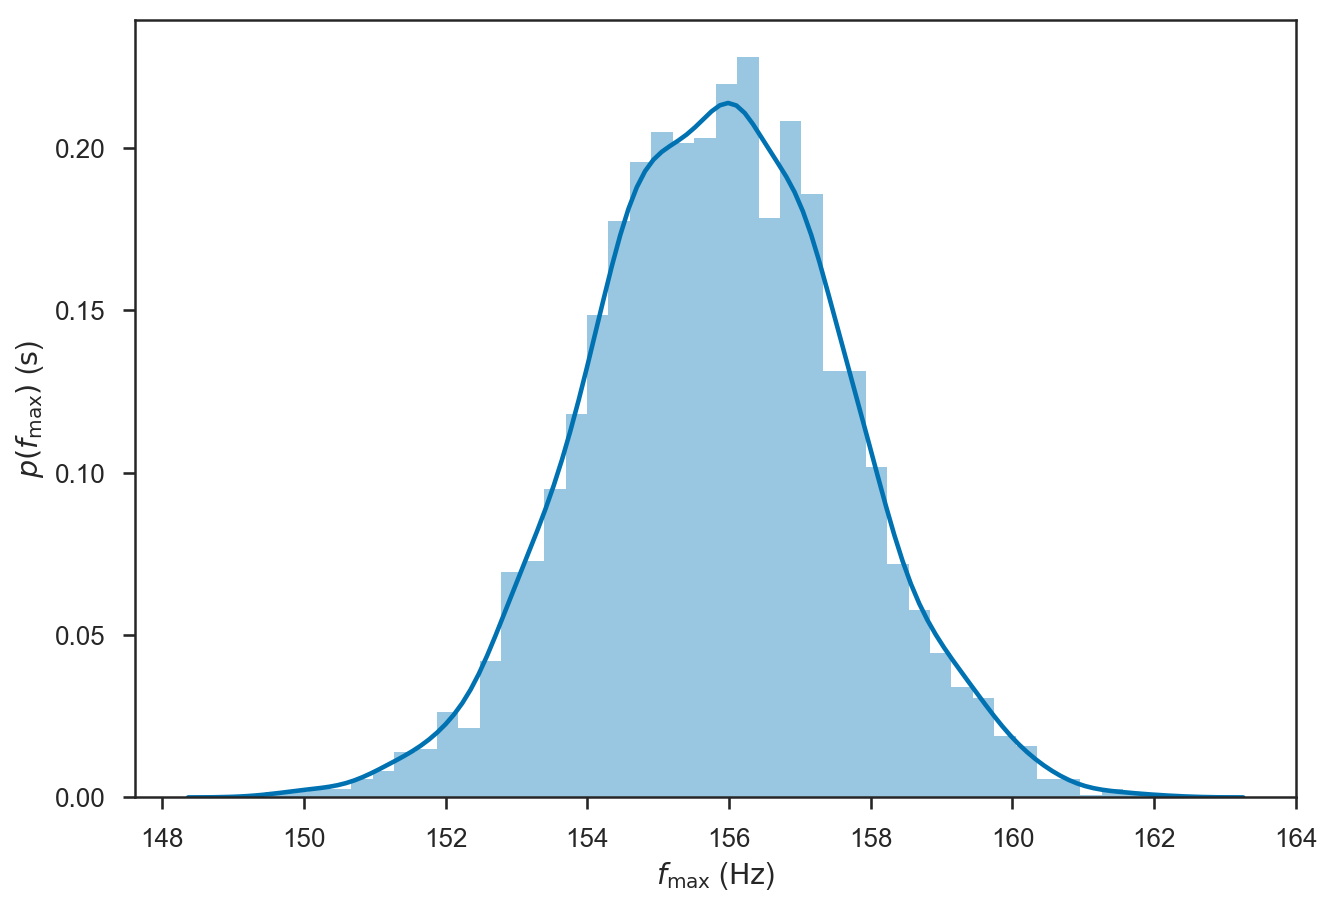

In [164]:
sns.distplot(chains['max_freq'])
xlabel(r'$f_\mathrm{max}$ ($\mathrm{Hz}$)')
ylabel(r'$p\left( f_\mathrm{max} \right)$ ($\mathrm{s}$)')

Now we will plot an uncertainty band on the w.f. from the fit (line is median, dark "$1\sigma$" or 68% interval, light "$2\sigma$ or 95% interval):

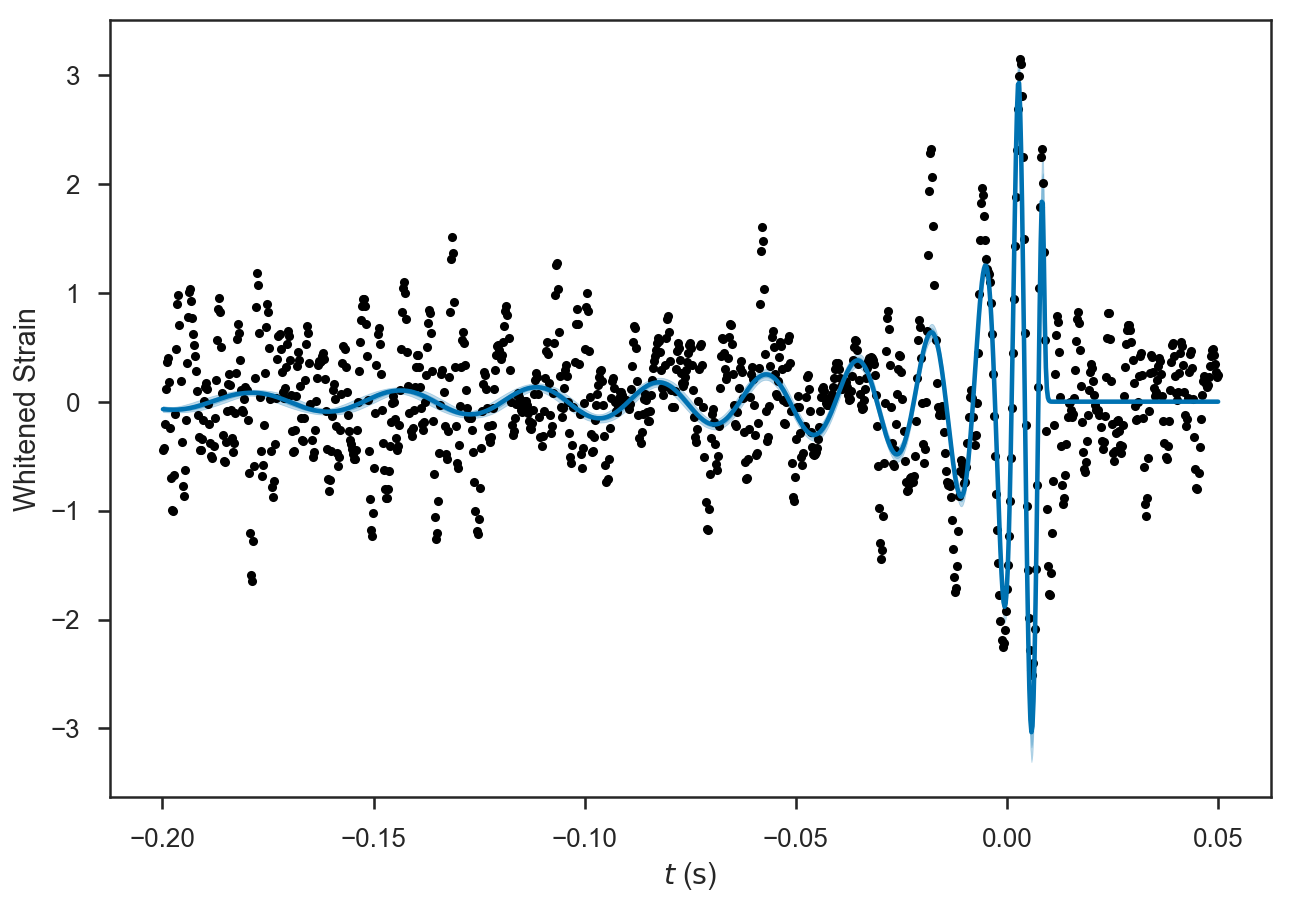

In [157]:
plot(time_h1[tselector]-tGW150914, white_pass_strain_h1[tselector], '.k')
plot(time_h1[tselector]-tGW150914, median(chains['h_model'], axis=0))
fill_between(time_h1[tselector]-tGW150914, percentile(chains['h_model'], 84, axis=0), percentile(chains['h_model'], 16, axis=0), alpha=0.25, color=sns.color_palette()[0])
fill_between(time_h1[tselector]-tGW150914, percentile(chains['h_model'], 97.5, axis=0), percentile(chains['h_model'], 2.5, axis=0), alpha=0.25, color=sns.color_palette()[0])
xlabel(r'$t$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

And a corner plot of all the parameters (not waveforms)---things are not terribly correlated.

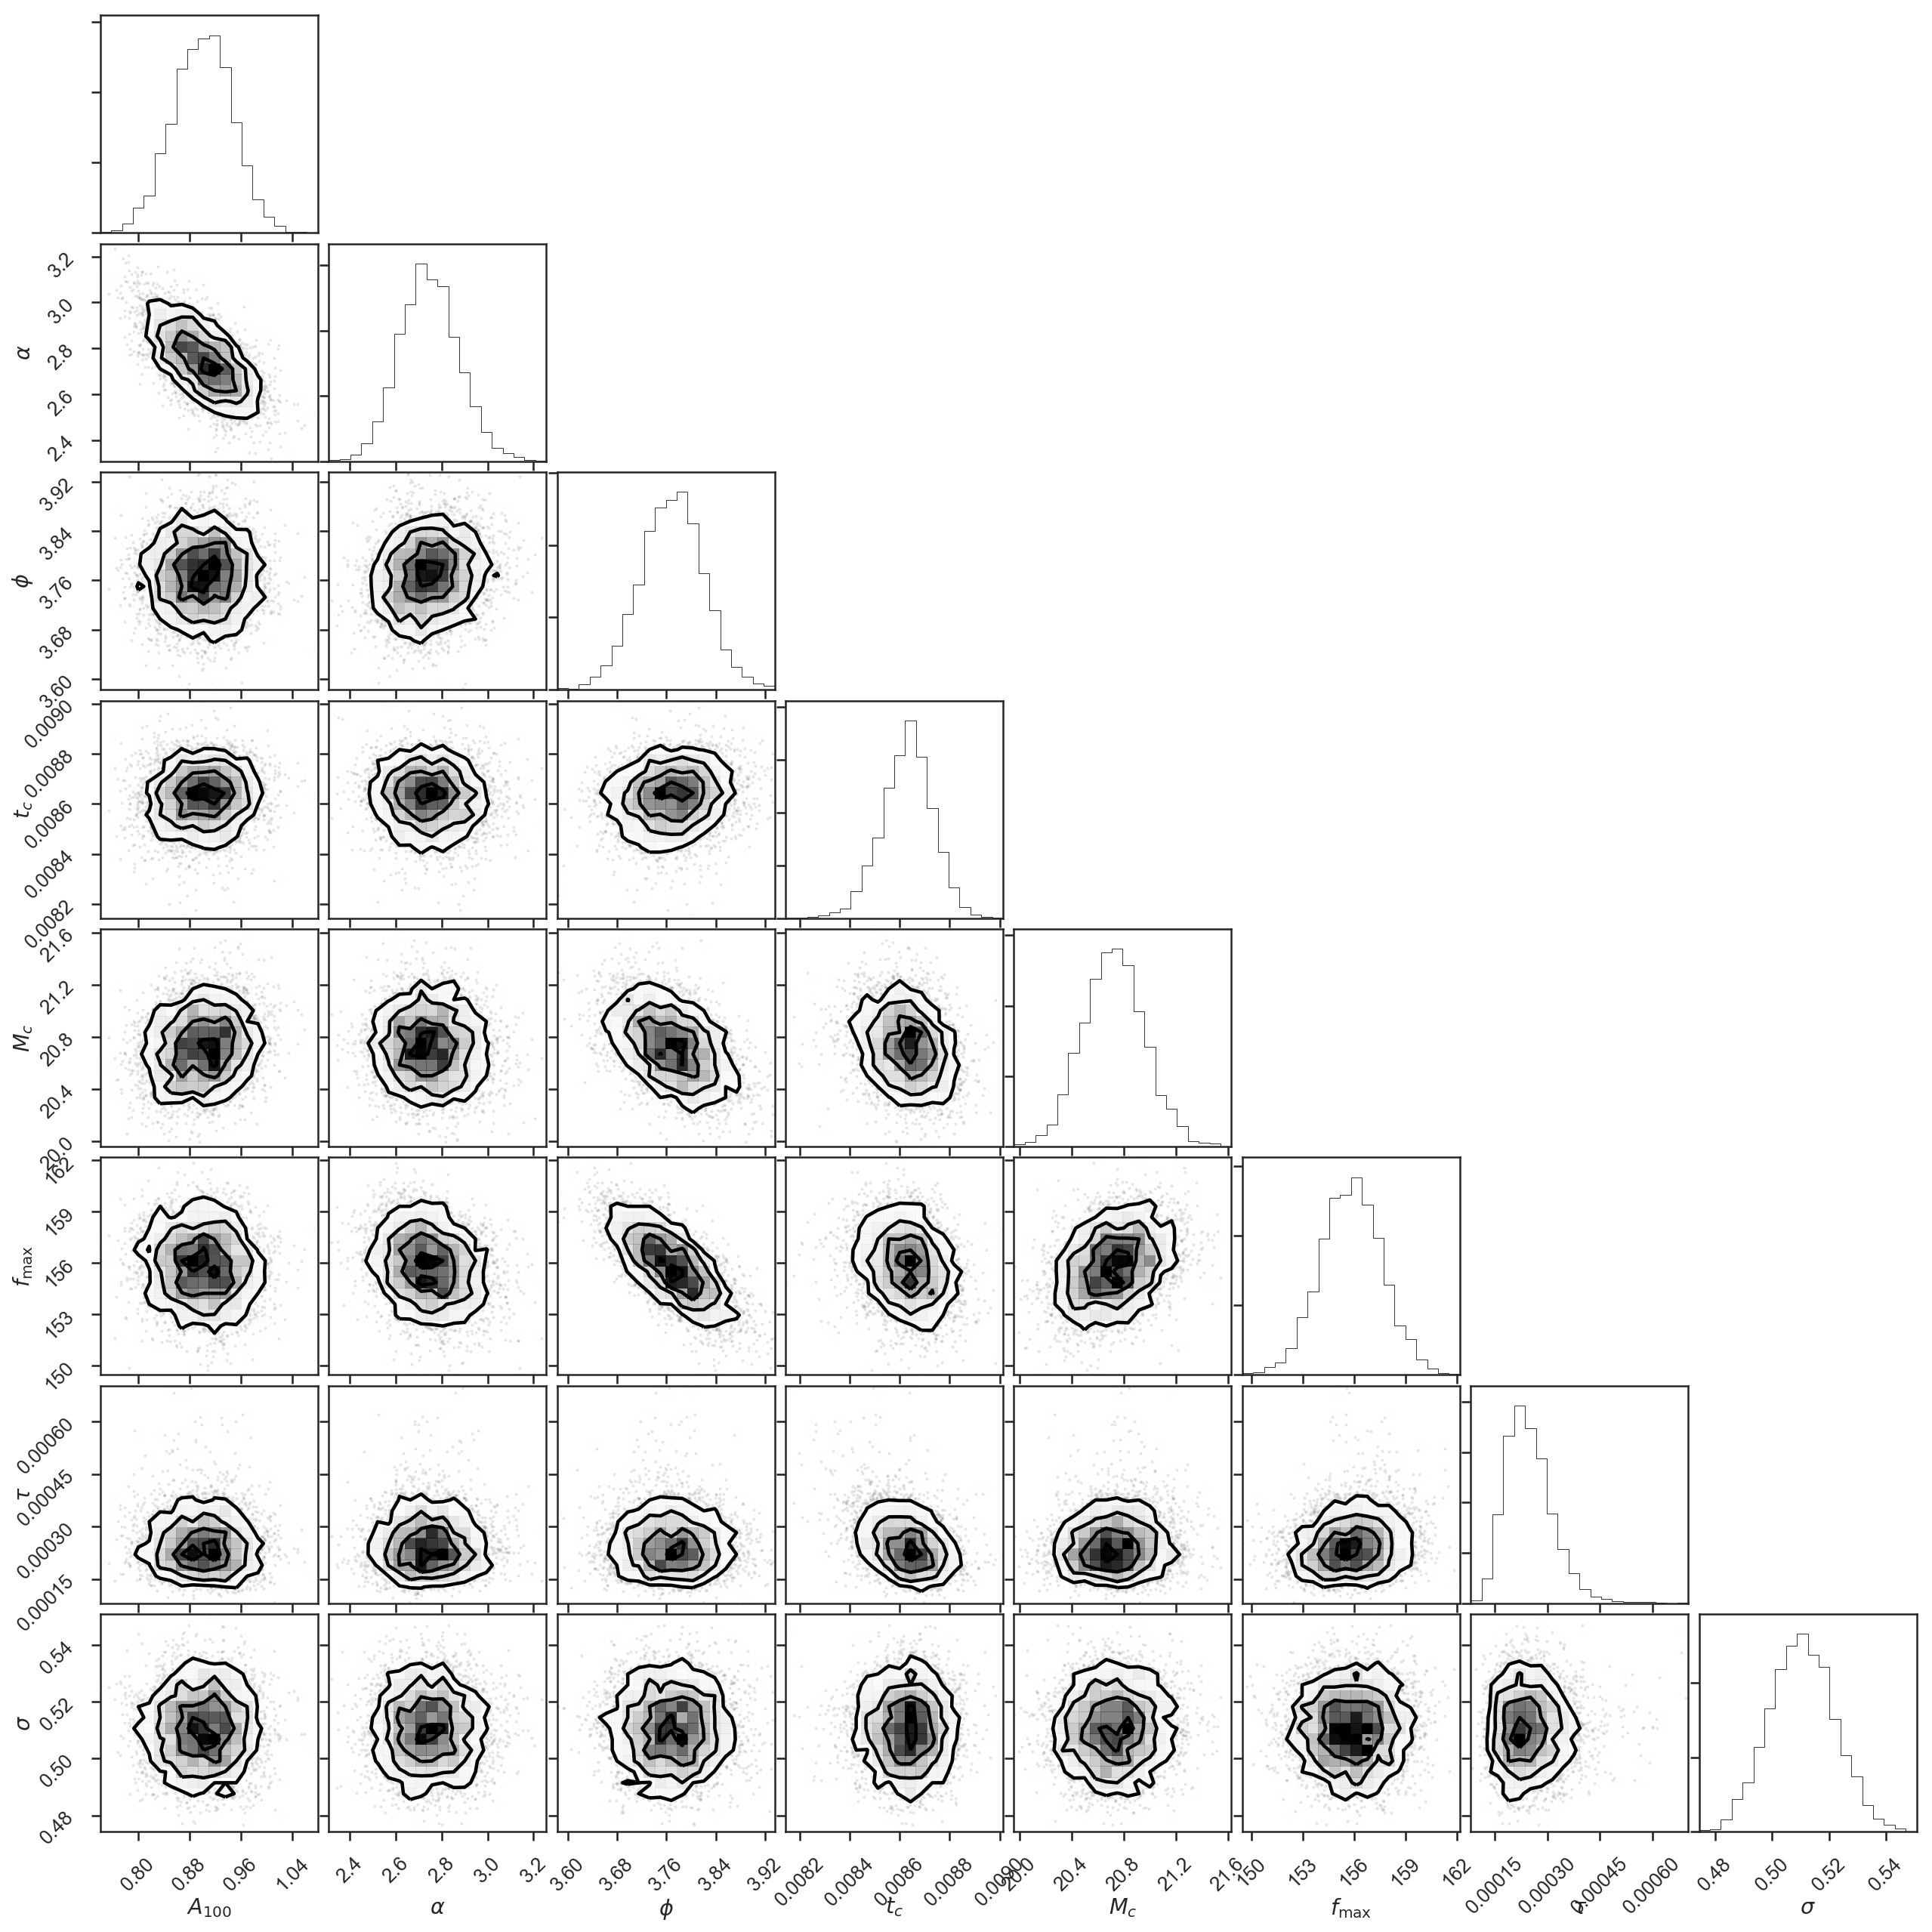

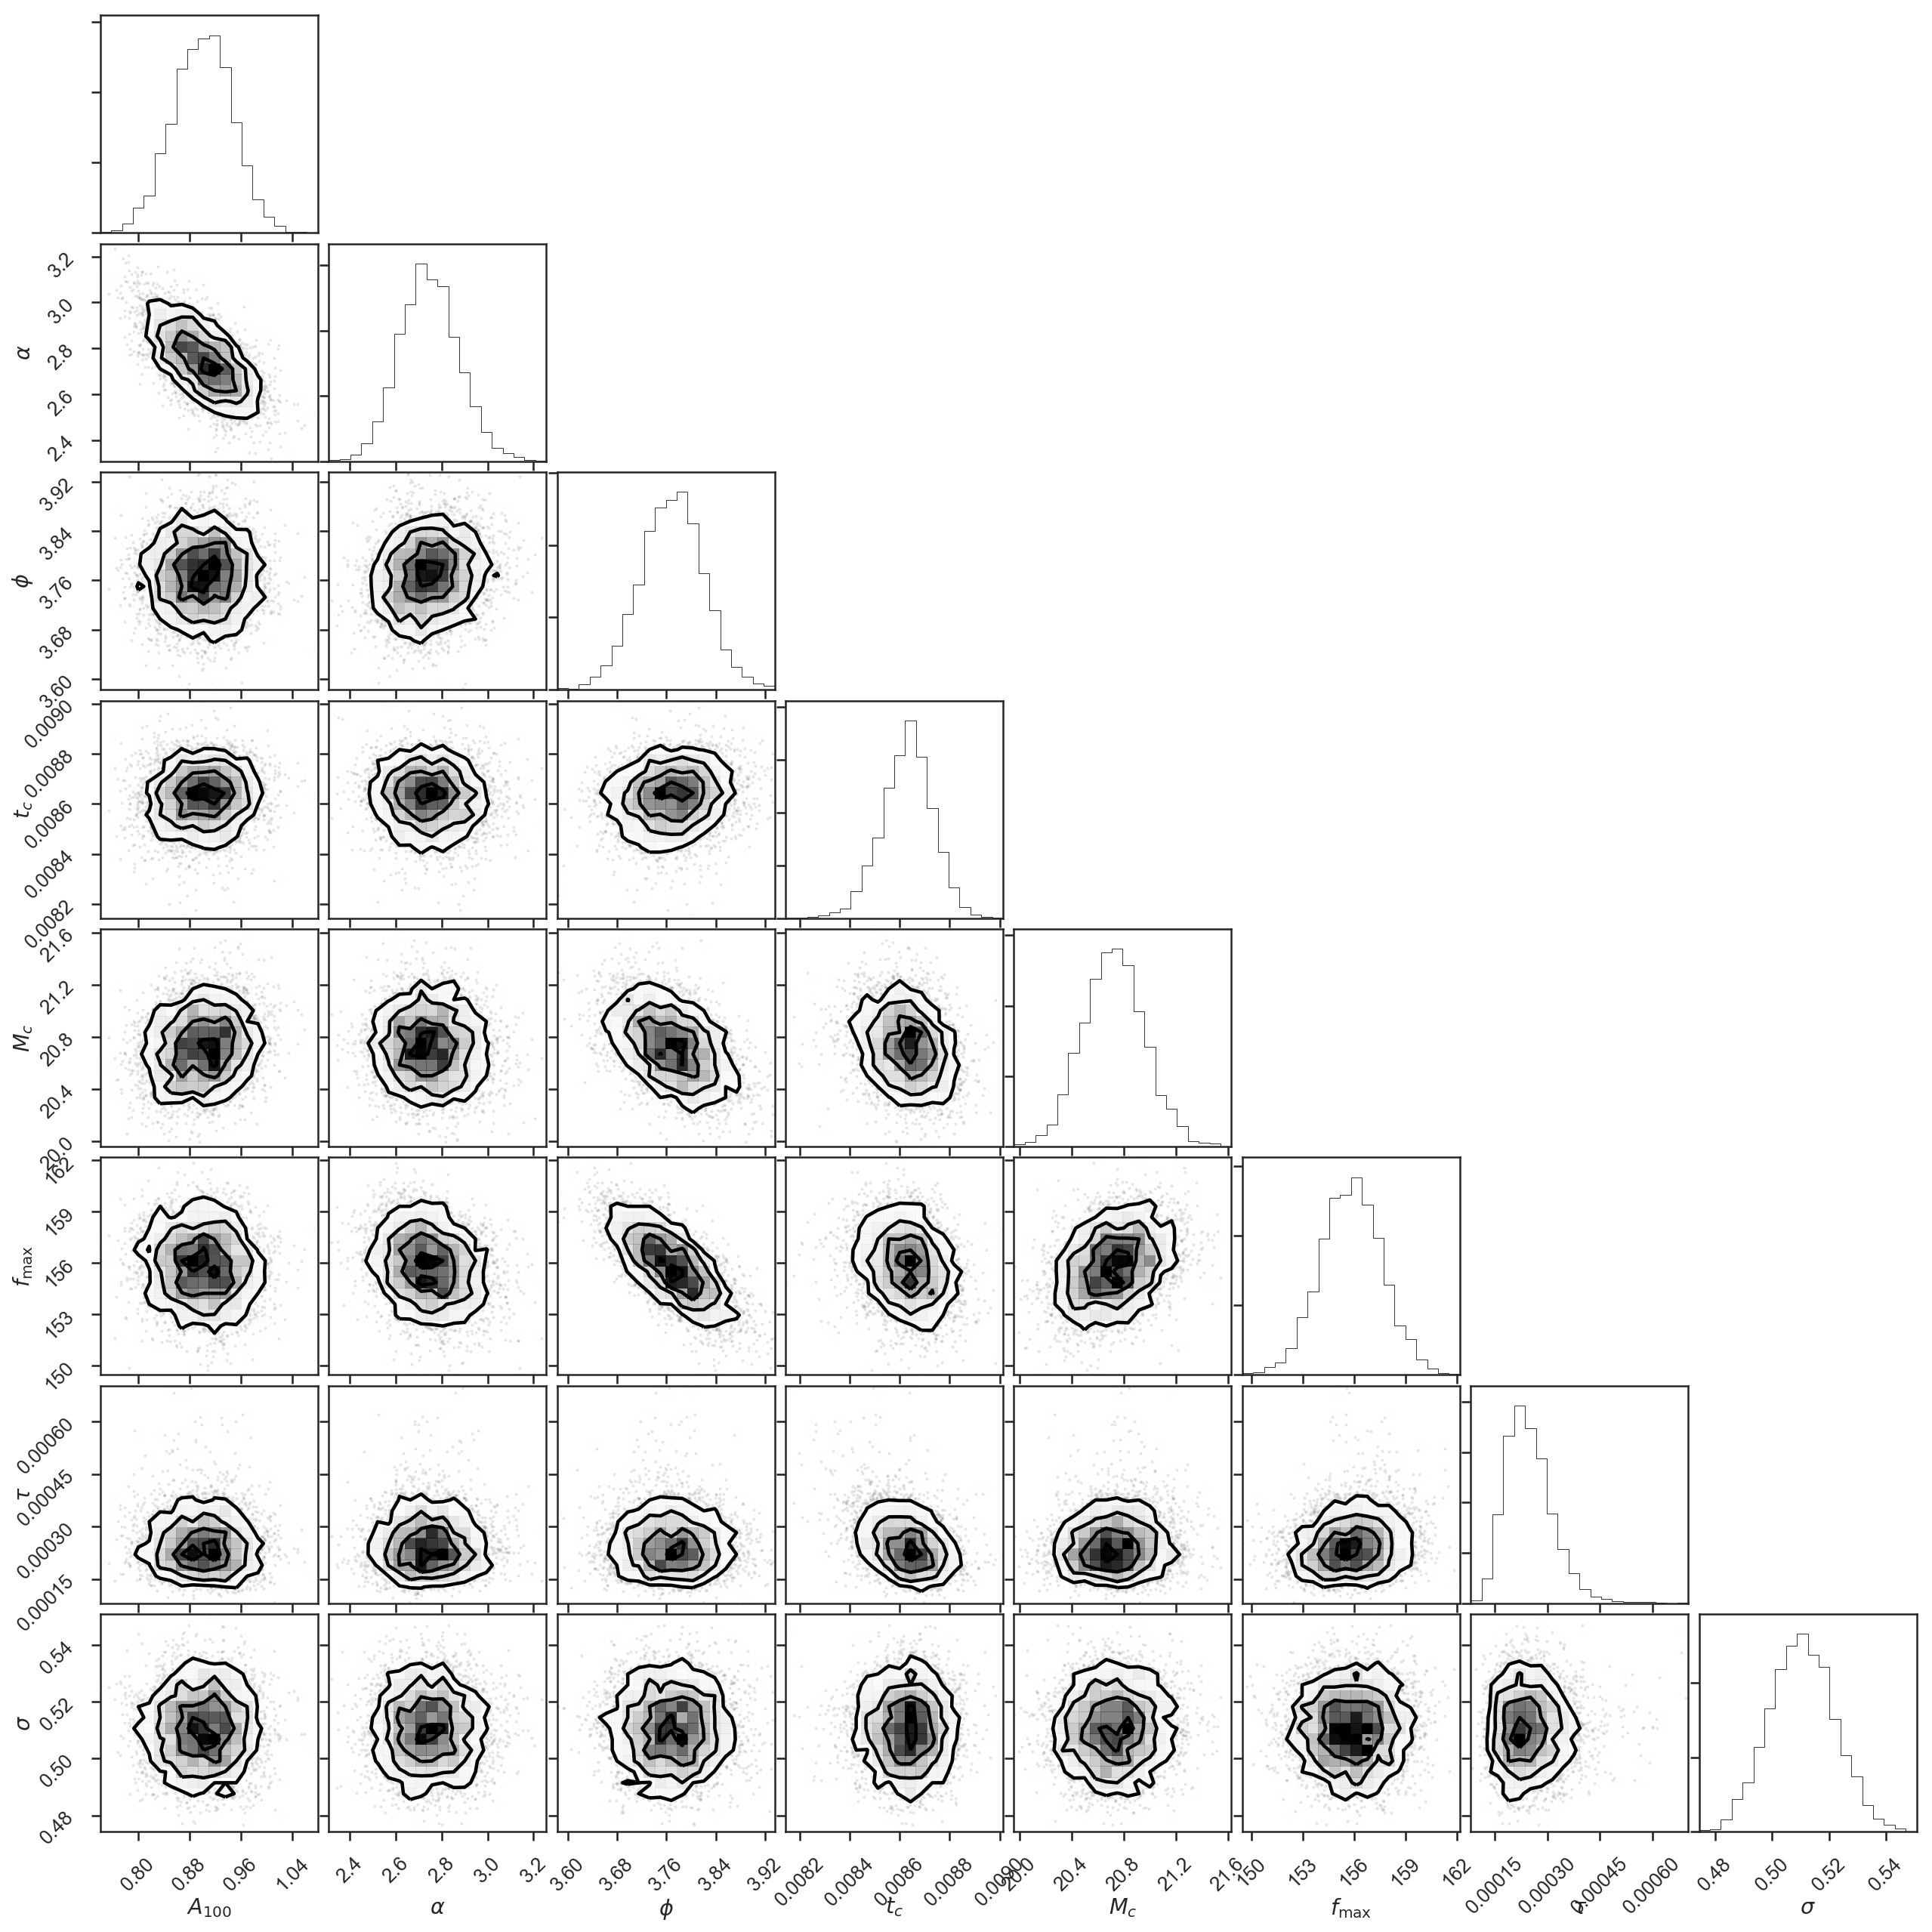

In [159]:
corner.corner(column_stack([chains[k] for k in ['A100', 'dlnAdlnf', 'phi', 'tc', 'Mc', 'max_freq', 'tau', 'sigma']]), labels=[r'$A_{100}$', r'$\alpha$', r'$\phi$', r'$t_c$', r'$M_c$', r'$f_\mathrm{max}$', r'$\tau$', r'$\sigma$'])

We discussed a number of ways we could improve this model:

 * No longer assume stationarity in data (i.e. [BayesWave](https://arxiv.org/abs/1410.3835)).
 * Incorporate more pN terms (and including spin)!
 * Add in additional detector data (requires different amplitude and phase in second detector, as discussed in lecture).
 * Test GR by modifying the phase formula from prediction using chirp mass and mass ratio.